In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

2023-11-06 13:41:27.138146: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 13:41:27.166377: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 13:41:27.166413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 13:41:27.166446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 13:41:27.173150: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 13:41:27.173978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
train_path = 'data/cats-dogs/train'
len(os.listdir(train_path))

25000

### Visualization Some pictures

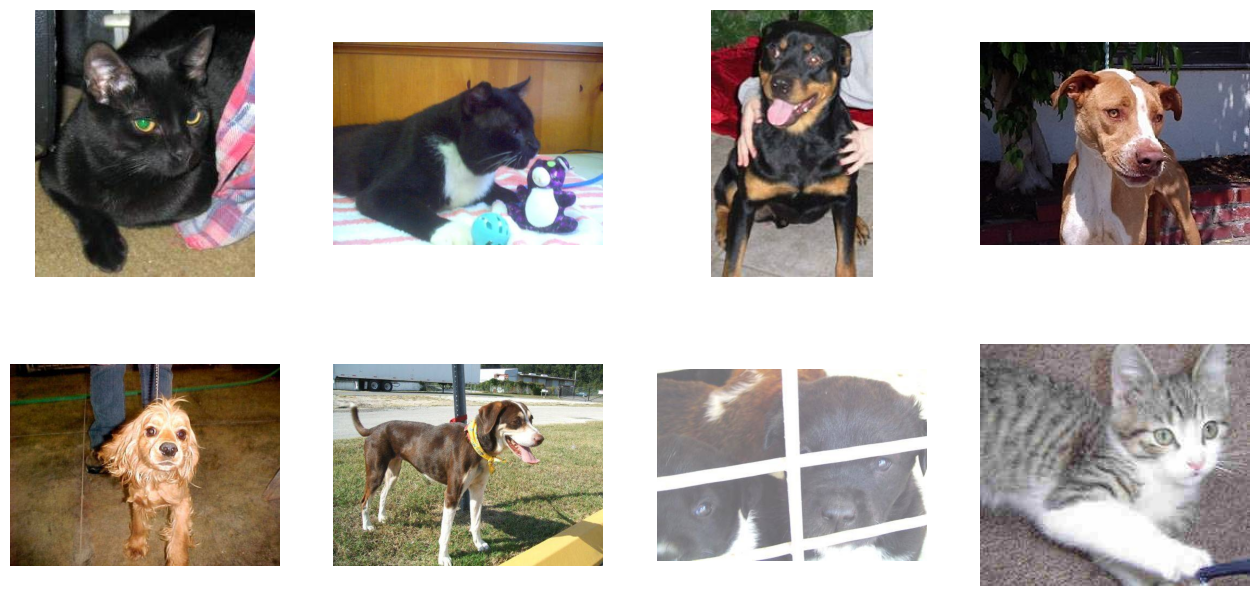

In [6]:
plt.figure(figsize=(16,16))
images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [7]:
os.listdir(train_path)[:20]

['dog.8659.jpg',
 'cat.4935.jpg',
 'cat.9291.jpg',
 'cat.10060.jpg',
 'dog.4013.jpg',
 'cat.140.jpg',
 'dog.4214.jpg',
 'dog.1732.jpg',
 'dog.2490.jpg',
 'dog.40.jpg',
 'dog.7974.jpg',
 'dog.2496.jpg',
 'cat.9960.jpg',
 'cat.2204.jpg',
 'cat.11976.jpg',
 'dog.2123.jpg',
 'dog.2865.jpg',
 'dog.9573.jpg',
 'cat.7511.jpg',
 'dog.5059.jpg']

### Organize the directories

In [9]:
for dir in ['training', 'validation']:
    path = os.path.join('data/cats-dogs' , dir)
    os.mkdir(path)
    for dir in ['cats', 'dogs']:
        n_path = os.path.join(path , dir)
        os.mkdir(n_path)

In [12]:
src_dir = train_path
cats_train_dir = 'data/cats-dogs/training/cats'
cats_valid_dir = 'data/cats-dogs/validation/cats'
dogs_train_dir = 'data/cats-dogs/training/dogs'
dogs_valid_dir = 'data/cats-dogs/validation/dogs'

cats = [img for img in os.listdir(src_dir) if img[:3] == 'cat']
dogs = [img for img in os.listdir(src_dir) if img[:3] == 'dog']

In [13]:
# Take 10% of training images for validation    
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [14]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)
    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)
    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [15]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


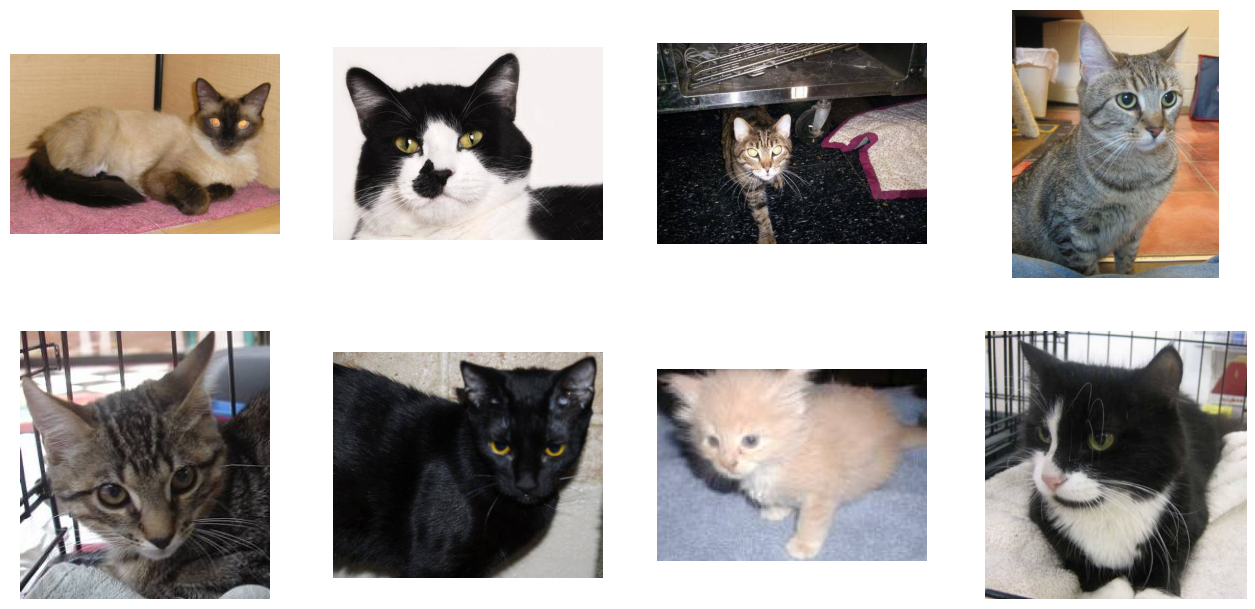

In [16]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

### Image Data Generator

In [17]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

In [18]:
train_dir = 'data/cats-dogs/training/'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
valid_dir = 'data/cats-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [19]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


### Modelling

In [20]:
# create model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

2023-11-06 14:56:44.482247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 14:56:44.582743: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
# Compile model 
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [22]:
# fit the model 
history = model.fit(train_generator, epochs=5, verbose=1, validation_data=valid_generator)

Epoch 1/5
704/704 [==============================] - 203s 288ms/step - loss: 0.5783 - accuracy: 0.6866 - val_loss: 0.5042 - val_accuracy: 0.7560
Epoch 2/5
704/704 [==============================] - 198s 281ms/step - loss: 0.4548 - accuracy: 0.7856 - val_loss: 0.4492 - val_accuracy: 0.7928
Epoch 3/5
704/704 [==============================] - 196s 279ms/step - loss: 0.3927 - accuracy: 0.8235 - val_loss: 0.3964 - val_accuracy: 0.8232
Epoch 4/5
704/704 [==============================] - 202s 287ms/step - loss: 0.3356 - accuracy: 0.8531 - val_loss: 0.3914 - val_accuracy: 0.8324
Epoch 5/5
704/704 [==============================] - 251s 356ms/step - loss: 0.2820 - accuracy: 0.8804 - val_loss: 0.3599 - val_accuracy: 0.8488
